# Proyecto Final: Bot Para la bolsa de valores.

<font color='BLUE'>
    
## Bibliografia

    
-------[Stock Price Prediction with PyTorch](https://medium.com/swlh/stock-price-prediction-with-pytorch-37f52ae84632)-------
    
-------[Predicting Stock Price with a Feature Fusion GRU-CNN Neural Network in PyTorch](https://medium.com/analytics-vidhya/predicting-stock-price-with-a-feature-fusion-gru-cnn-neural-network-in-pytorch-1220e1231911)-------

### 1) Importación de librerias

In [1]:
import pandas as pd
import numpy  as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable

### 2) Carga del dataset.

In [2]:
# CARGA DE DATOS.

dfx = pd.read_csv("df_var_x.csv")
dfy = pd.read_csv("df_var_y.csv")

###  3) Análisis de los inputs.

Como primera columna podremmos ver el símbolo o abreviatura que representa a la empresa en la empresa en la bolsa.

Así como los cambios sufridos en su precio a distintas ventanas de tiempo.

Y otros indicadores que pueden ser útiles en la predicción.

In [3]:
dfx.tail()

,Ticker,Volumen,PER,Cambio(%) 1_min,Cambio(%) 5_min,Cambio(%) 15_min,Cambio(%) 1_hr,Cambio(%) 4_hr,Cambio(%) 1_sem,Cambio(%) 1_mes,...,RSI,Estocástico,Estocástico D,Valoracion Medias Mov.,SMA20,SMA50,SMA200,B Bollinger Up,B Bollinger Low,Fecha
14420,SIRI,67000000.0,29.12,0.00,3.28,3.28,3.28,3.28,10.89,3.28,...,59.49,36.82,51.29,-1,6.16700,6.3138,5.900175,6.772313,5.561687,29-ene-21
14421,SPLK,1000000.0,0.00,0.15,-0.18,-0.18,-0.18,-0.18,-1.75,-2.52,...,44.40,46.69,59.81,1,168.85775,174.6511,184.865600,175.288788,162.426712,29-ene-21
14422,TCOM,4000000.0,0.00,0.03,-1.07,-1.07,-1.07,-1.07,-4.06,0.58,...,43.71,33.84,24.41,1,33.19075,33.5497,29.443075,34.585419,31.796081,29-ene-21
14423,WDAY,2000000.0,0.00,0.29,-0.56,-0.56,-0.56,-0.56,-3.48,-4.37,...,48.16,36.74,48.27,1,228.15025,228.2767,200.989000,237.976755,218.323745,29-ene-21
14424,ZM,3000000.0,258.90,0.70,1.86,1.86,1.86,1.86,0.61,9.04,...,52.56,64.44,63.00,-1,368.28700,391.4666,330.343625,404.474532,332.099468,29-ene-21


Aqui los datos que quedan sobrando son la fecha y el identificador de la empresa por lo que  vamos a elimanarlo.

In [4]:
dfx = dfx.drop("Ticker",1)
dfx = dfx.drop("Fecha" ,1)

dfx.tail()

,Volumen,PER,Cambio(%) 1_min,Cambio(%) 5_min,Cambio(%) 15_min,Cambio(%) 1_hr,Cambio(%) 4_hr,Cambio(%) 1_sem,Cambio(%) 1_mes,Cambio(%) 3_meses,...,Momento,RSI,Estocástico,Estocástico D,Valoracion Medias Mov.,SMA20,SMA50,SMA200,B Bollinger Up,B Bollinger Low
14420,67000000.0,29.12,0.00,3.28,3.28,3.28,3.28,10.89,3.28,16.14,...,0.790,59.49,36.82,51.29,-1,6.16700,6.3138,5.900175,6.772313,5.561687
14421,1000000.0,0.00,0.15,-0.18,-0.18,-0.18,-0.18,-1.75,-2.52,-18.38,...,-3.045,44.40,46.69,59.81,1,168.85775,174.6511,184.865600,175.288788,162.426712
14422,4000000.0,0.00,0.03,-1.07,-1.07,-1.07,-1.07,-4.06,0.58,9.84,...,-0.785,43.71,33.84,24.41,1,33.19075,33.5497,29.443075,34.585419,31.796081
14423,2000000.0,0.00,0.29,-0.56,-0.56,-0.56,-0.56,-3.48,-4.37,8.41,...,0.005,48.16,36.74,48.27,1,228.15025,228.2767,200.989000,237.976755,218.323745
14424,3000000.0,258.90,0.70,1.86,1.86,1.86,1.86,0.61,9.04,-25.25,...,2.500,52.56,64.44,63.00,-1,368.28700,391.4666,330.343625,404.474532,332.099468


In [5]:
columnas=dfx.columns
t = PrettyTable(['columna','variable independiente'])
for i in range(len(columnas)):
    t.add_row([i,columnas[i]])
print(t)

+---------+---------------------------+
| columna |   variable independiente  |
+---------+---------------------------+
|    0    |          Volumen          |
|    1    |            PER            |
|    2    |      Cambio(%) 1_min      |
|    3    |      Cambio(%) 5_min      |
|    4    |      Cambio(%) 15_min     |
|    5    |       Cambio(%) 1_hr      |
|    6    |       Cambio(%) 4_hr      |
|    7    |      Cambio(%) 1_sem      |
|    8    |      Cambio(%) 1_mes      |
|    9    |     Cambio(%) 3_meses     |
|    10   |     Cambio(%) 6_meses     |
|    11   |      Cambio(%) 1_año      |
|    12   |        Volatilidad        |
|    13   | valoracion de osciladores |
|    14   |            ADX            |
|    15   |             AO            |
|    16   |            ATR            |
|    17   |           CCI20           |
|    18   |         Nivel MACD        |
|    19   |         Señal MACD        |
|    20   |          Momento          |
|    21   |            RSI            |


Veamos algunas de sus estadísticas y las carácteristicas del dataset.

In [6]:
dfx.describe()

,Volumen,PER,Cambio(%) 1_min,Cambio(%) 5_min,Cambio(%) 15_min,Cambio(%) 1_hr,Cambio(%) 4_hr,Cambio(%) 1_sem,Cambio(%) 1_mes,Cambio(%) 3_meses,...,Momento,RSI,Estocástico,Estocástico D,Valoracion Medias Mov.,SMA20,SMA50,SMA200,B Bollinger Up,B Bollinger Low
count,1.441900e+04,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14423.000000,...,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14425.000000,14387.000000,14425.000000,14425.000000
mean,1.982280e+06,37.141188,-0.002026,-0.016392,0.024916,0.053379,0.118383,0.702211,3.510592,17.282009,...,2.451606,55.265822,55.699878,56.254239,-0.409497,174.714015,170.000373,150.994595,184.172332,165.255697
std,7.627247e+06,81.604500,0.146403,0.395025,0.822434,0.998896,1.282528,4.388042,8.213816,20.407920,...,21.406118,10.805324,26.828741,25.351811,0.884485,311.683230,306.654487,272.012909,327.560937,296.098889
min,0.000000e+00,0.000000,-1.780000,-5.120000,-15.460000,-15.270000,-15.460000,-18.690000,-88.160000,-89.230000,...,-301.495000,12.440000,0.850000,0.690000,-1.000000,6.115630,5.411500,5.230075,6.514515,-17.315843
25%,8.400000e+04,13.590000,-0.060000,-0.140000,-0.210000,-0.340000,-0.510000,-1.860000,-1.460000,3.335000,...,-1.960000,47.710000,32.000000,34.050000,-1.000000,50.638750,48.392200,43.081850,53.550836,47.575664
50%,3.600000e+05,25.050000,0.000000,-0.020000,-0.020000,-0.020000,0.050000,0.270000,2.440000,13.830000,...,0.520000,54.900000,59.170000,59.780000,-1.000000,103.390500,99.633800,90.439650,108.571620,96.920885
75%,1.000000e+06,38.540000,0.060000,0.090000,0.180000,0.330000,0.660000,2.640000,7.450000,27.160000,...,4.340000,62.640000,80.000000,78.980000,1.000000,186.883500,179.694600,163.107888,201.217688,174.056558
max,3.190000e+08,1764.770000,2.060000,22.310000,28.870000,28.870000,28.870000,35.060000,59.460000,168.030000,...,610.000000,89.940000,99.480000,98.470000,1.000000,4180.056000,4141.338800,3787.922650,4643.357988,3914.264890


La pregunta fundamental de este proyecto es reponder a la pregunta  <b>¿Es posible predecir los precios de las acciones?</b> 
 
Para empezar veamos como cambia la distribuición de cambios confrome avanza el tiempo.

Text(0.5, 1.0, 'Cambios a 1 semana.')

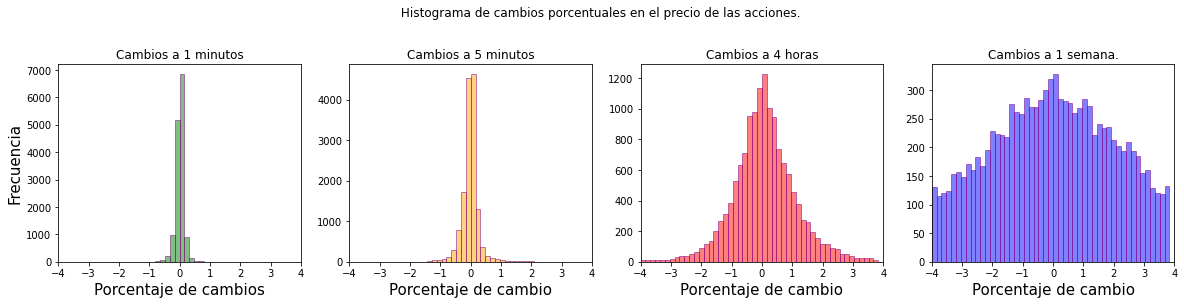

In [7]:
bins = [-4 + i*0.16 for i in range(50)]

plt.figure(figsize=(20,8))
plt.suptitle(" Histograma de cambios porcentuales en el precio de las acciones.")

ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,2)
ax3 = plt.subplot(2,4,3)
ax4 = plt.subplot(2,4,4)

ax1.hist(dfx["Cambio(%) 1_min"], bins=bins, color='green',edgecolor='purple', alpha=0.5)
ax1.set_xlabel('Porcentaje de cambios', size=15)
ax1.set_ylabel('Frecuencia', size=15)
ax1.set_xlim([-4,4])
ax1.set_title("Cambios a 1 minutos")

ax2.hist(dfx["Cambio(%) 5_min"], bins=bins, color='orange',edgecolor='purple', alpha=0.5)
ax2.set_xlabel('Porcentaje de cambio', size=15)
ax2.set_xlim([-4,4])
ax2.set_title("Cambios a 5 minutos")

ax3.hist(dfx["Cambio(%) 4_hr"], bins=bins, color='red',edgecolor='purple', alpha=0.5)
ax3.set_xlabel('Porcentaje de cambio', size=15)
ax3.set_xlim([-4,4])
ax3.set_title("Cambios a 4 horas")


ax4.hist(dfx["Cambio(%) 1_sem"], bins=bins, color='blue',edgecolor='purple', alpha=0.5)
ax4.set_xlabel('Porcentaje de cambio', size=15);
ax4.set_xlim([-4,4])
ax4.set_title("Cambios a 1 semana.")

Como podemos ver, la distribuición de cambio parece una distriuición normal centrada aproximadamente en el 0, y con desviación estandar que aumenta con el tiempo.

Lo que nos dice esto es que estadísticamente los precios siempre estan cambiando y van en general alejandose de su precio actual. 

Sin embargo podemos ver que el promedio a ventanas grandes de tiempo esta centrada más bien en un número positivo. Esto refleja el hecho que la economía en terminos generales  tiende a un creciemiento. (Ver las tablas de algunas celdas más arriba en dfx.describe())

Este último hecho nos da un referencia con la cual comparar nuestro algortimo. Por ejemplo el promedio de cambio porcentual a 3 meses es del 17% , por lo para cantar victoria con nuestros modelos y decir que es mejor que hacer compras de acciones al azar, el modelo tiene que elegir comprar acciones cuyo promedio de cambio supere el 17% a 3 meses. 


<b> Sobre las otros categorias. </b>

Las demás categorias presentes en los datos de entrada corresponden a indicadores del movimiento del mercado, como lo puede ser el promedio de cambio de precio en algun intervalo de tiempo. Por lo que puede ser útil para la red tenerlos presentes durante el entrenamiento e inferencia.


### 4)  Analizando el dataframe de los label

En este caso proponemos  como predicción del modelo predecir como se va a mover el precio a una ventana de 1 día. Por lo que etiquetamos con un 1 a las acciones que subieron de precio, con un cero a las acciones que no subieron de precio.

In [8]:
dfy.tail()

,Ticker,Cambio(%) 1_dia,Fecha
14420,SIRI,-1,29/Enero/2021
14421,SPLK,-1,29/Enero/2021
14422,TCOM,-1,29/Enero/2021
14423,WDAY,-1,29/Enero/2021
14424,ZM,-1,29/Enero/2021


Eliminamos las columnas inecesareas.

In [9]:
dfy = pd.DataFrame({"Cambio(%) 1_dia":dfy["Cambio(%) 1_dia"]})

In [10]:
dfy.tail()

,Cambio(%) 1_dia
14420,-1
14421,-1
14422,-1
14423,-1
14424,-1


Text(0.5, 1.0, 'Cambios a 1 minutos')

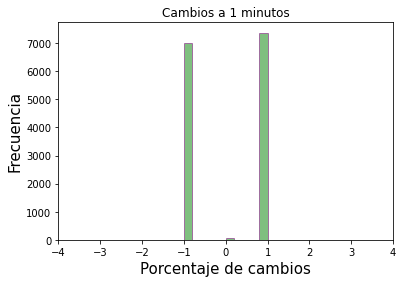

In [11]:
ax5 = plt.subplot(1,1,1)
ax5.hist(dfy["Cambio(%) 1_dia"], color='green',edgecolor='purple', alpha=0.5)
ax5.set_xlabel('Porcentaje de cambios', size=15)
ax5.set_ylabel('Frecuencia', size=15)
ax5.set_xlim([-4,4])
ax5.set_title("Cambios a 1 minutos")

###  5) Buscamos  datos faltantes.

In [12]:
dfx.isnull().sum()

Volumen                       6
PER                           0
Cambio(%) 1_min               0
Cambio(%) 5_min               0
Cambio(%) 15_min              0
Cambio(%) 1_hr                0
Cambio(%) 4_hr                0
Cambio(%) 1_sem               0
Cambio(%) 1_mes               0
Cambio(%) 3_meses             2
Cambio(%) 6_meses            26
Cambio(%) 1_año              78
Volatilidad                   0
valoracion de osciladores     0
ADX                           0
AO                            0
ATR                           0
CCI20                         0
Nivel MACD                    0
Señal MACD                    0
Momento                       0
RSI                           0
Estocástico                   0
Estocástico D                 0
Valoracion Medias Mov.        0
SMA20                         0
SMA50                         0
SMA200                       38
B Bollinger Up                0
B Bollinger Low               0
dtype: int64

Vemos que si hay datos faltantes, los eliminaremos directamente del dataset.

In [13]:
all_data = pd.concat([dfx,dfy],axis=1,join="inner")
all_data = all_data.dropna()
dfy = all_data["Cambio(%) 1_dia"]
dfx = all_data.drop("Cambio(%) 1_dia",1)

dfx.isnull().sum()

Volumen                      0
PER                          0
Cambio(%) 1_min              0
Cambio(%) 5_min              0
Cambio(%) 15_min             0
Cambio(%) 1_hr               0
Cambio(%) 4_hr               0
Cambio(%) 1_sem              0
Cambio(%) 1_mes              0
Cambio(%) 3_meses            0
Cambio(%) 6_meses            0
Cambio(%) 1_año              0
Volatilidad                  0
valoracion de osciladores    0
ADX                          0
AO                           0
ATR                          0
CCI20                        0
Nivel MACD                   0
Señal MACD                   0
Momento                      0
RSI                          0
Estocástico                  0
Estocástico D                0
Valoracion Medias Mov.       0
SMA20                        0
SMA50                        0
SMA200                       0
B Bollinger Up               0
B Bollinger Low              0
dtype: int64

Como se puede ver ya no hay datos faltantes. 

In [14]:
print(dfx.shape)
print(dfy.shape)

dfx.tail()

(14341, 30)
(14341,)


,Volumen,PER,Cambio(%) 1_min,Cambio(%) 5_min,Cambio(%) 15_min,Cambio(%) 1_hr,Cambio(%) 4_hr,Cambio(%) 1_sem,Cambio(%) 1_mes,Cambio(%) 3_meses,...,Momento,RSI,Estocástico,Estocástico D,Valoracion Medias Mov.,SMA20,SMA50,SMA200,B Bollinger Up,B Bollinger Low
14420,67000000.0,29.12,0.00,3.28,3.28,3.28,3.28,10.89,3.28,16.14,...,0.790,59.49,36.82,51.29,-1,6.16700,6.3138,5.900175,6.772313,5.561687
14421,1000000.0,0.00,0.15,-0.18,-0.18,-0.18,-0.18,-1.75,-2.52,-18.38,...,-3.045,44.40,46.69,59.81,1,168.85775,174.6511,184.865600,175.288788,162.426712
14422,4000000.0,0.00,0.03,-1.07,-1.07,-1.07,-1.07,-4.06,0.58,9.84,...,-0.785,43.71,33.84,24.41,1,33.19075,33.5497,29.443075,34.585419,31.796081
14423,2000000.0,0.00,0.29,-0.56,-0.56,-0.56,-0.56,-3.48,-4.37,8.41,...,0.005,48.16,36.74,48.27,1,228.15025,228.2767,200.989000,237.976755,218.323745
14424,3000000.0,258.90,0.70,1.86,1.86,1.86,1.86,0.61,9.04,-25.25,...,2.500,52.56,64.44,63.00,-1,368.28700,391.4666,330.343625,404.474532,332.099468


### 6) Normalización de los datos.

In [15]:
#se juntan los datos para revolverlos
#dfx = dfx.assign(Y=dfy.values)

#se revuelven
#dfx = dfx.sample(frac=1)

#se separan de nuevo
#dfy = pd.DataFrame({"Cambio(%) 1_dia":dfx["Y"]})
#dfx = dfx.drop("Y" ,1)

#se normalizan
dfx_norm = ( dfx - dfx.mean() ) / dfx.std()
dfx_norm.tail()

,Volumen,PER,Cambio(%) 1_min,Cambio(%) 5_min,Cambio(%) 15_min,Cambio(%) 1_hr,Cambio(%) 4_hr,Cambio(%) 1_sem,Cambio(%) 1_mes,Cambio(%) 3_meses,...,Momento,RSI,Estocástico,Estocástico D,Valoracion Medias Mov.,SMA20,SMA50,SMA200,B Bollinger Up,B Bollinger Low
14420,8.502868,-0.099462,0.013653,8.343938,3.956697,3.229836,2.464169,2.319963,-0.029129,-0.057508,...,-0.078909,0.389533,-0.703082,-0.194900,-0.667013,-0.555117,-0.548552,-0.548244,-0.556441,-0.553102
14421,-0.128974,-0.455354,1.042703,-0.413374,-0.249514,-0.234182,-0.233243,-0.559383,-0.733830,-1.745918,...,-0.269387,-1.005720,-0.335283,0.140989,1.595436,-0.016271,0.018953,0.133573,-0.024840,-0.006795
14422,0.263383,-0.455354,0.219463,-2.665977,-1.331458,-1.125215,-0.927086,-1.085593,-0.357179,-0.365648,...,-0.157136,-1.069519,-0.814130,-1.254606,1.595436,-0.465612,-0.456734,-0.458551,-0.468702,-0.461737
14423,0.001812,-0.455354,2.003151,-1.375160,-0.711468,-0.614623,-0.529491,-0.953471,-0.958605,-0.435591,...,-0.117898,-0.658062,-0.706064,-0.313959,1.595436,0.180111,0.199738,0.195000,0.172916,0.187875
14424,0.132597,2.708811,4.815889,4.749897,2.230448,1.808187,1.357138,-0.021784,0.670713,-2.081938,...,0.006025,-0.251229,0.326160,0.266750,-0.667013,0.644256,0.749890,0.687811,0.698149,0.584117


### 7) Generamos los conjuntos de entrenamineto y de test.

In [16]:
TEST_RATIO = 0.2

train_ratio = int((1.0-TEST_RATIO)*len(dfx.values[:,:]))

dfx_train = dfx_norm.iloc[0:train_ratio,:]
dfy_train = dfy.iloc[0:train_ratio]

dfx_test  = dfx_norm.iloc[train_ratio:,:]
dfy_test  = dfy.iloc[train_ratio:]

t = PrettyTable(['Arreglo','dimensión'])
t.add_row(['train_x',dfx_train.shape])
t.add_row(['train_y',dfy_train.shape])
t.add_row(['test_x',dfx_test.shape])
t.add_row(['test_y',dfy_test.shape])
print(t)

+---------+-------------+
| Arreglo |  dimensión  |
+---------+-------------+
| train_x | (11472, 30) |
| train_y |   (11472,)  |
|  test_x |  (2869, 30) |
|  test_y |   (2869,)   |
+---------+-------------+


### 8) Obtenemos los datos en formato numpy.

In [17]:
# Obtenemos los valores del dataframe.

x_train = dfx_train.to_numpy()
y_train = dfy_train.to_numpy()

x_test  = dfx_test.to_numpy()
y_test  = dfy_test.to_numpy()

t = PrettyTable(['Arreglo','dimensión'])
t.add_row(['train_x',x_train.shape])
t.add_row(['train_y',y_train.shape])
t.add_row(['test_x',x_test.shape])
t.add_row(['test_y',y_test.shape])
print(t)

+---------+-------------+
| Arreglo |  dimensión  |
+---------+-------------+
| train_x | (11472, 30) |
| train_y |   (11472,)  |
|  test_x |  (2869, 30) |
|  test_y |   (2869,)   |
+---------+-------------+


### 9) Transformación a tensores.

In [18]:
muestras_x_train=x_train.shape[0]
muestras_x_test=x_test.shape[0]
salida=1

x_train =torch.from_numpy(np.asarray(x_train)).type(torch.Tensor)
x_test = torch.from_numpy(np.asarray(x_test)).type(torch.Tensor)
y_train = torch.from_numpy(np.asarray(y_train)).type(torch.Tensor)
y_test = torch.from_numpy(np.asarray(y_test)).type(torch.Tensor)



#conversión 2d a tensor de 3 dimensiones
x_train =torch.reshape(x_train,(1,muestras_x_train,len(columnas)))
x_test = torch.reshape(x_test,(1,muestras_x_test,len(columnas)))
y_train = torch.reshape(y_train,(1,muestras_x_train,salida))
y_test = torch.reshape(y_test,(1,muestras_x_test,salida))



#entradas tensor=(batch,len,features)
t = PrettyTable(['Arreglo','dimensión'])
t.add_row(['train_x',x_train.shape])
t.add_row(['test_x',x_test.shape])
t.add_row(['train_y',y_train.shape])
t.add_row(['test_y',y_test.shape])
print(t)



+---------+----------------------------+
| Arreglo |         dimensión          |
+---------+----------------------------+
| train_x | torch.Size([1, 11472, 30]) |
|  test_x | torch.Size([1, 2869, 30])  |
| train_y | torch.Size([1, 11472, 1])  |
|  test_y |  torch.Size([1, 2869, 1])  |
+---------+----------------------------+


### 10) Definimos algunos hiperparámetros.

In [19]:
input_dim = len(columnas)
hidden_dim = 60
num_layers = 3
output_dim = y_train.shape[1]
num_epochs = 150

### 11) arquitectura red LSTM .

Una red neuronal recurrente (RNN) es un tipo de red neuronal artificial diseñada para reconocer patrones secuenciales de datos para predecir los siguientes escenarios. Esta arquitectura es especialmente poderosa debido a sus conexiones de nodos, lo que permite la exhibición de un comportamiento dinámico temporal.

La memoria a largo y corto plazo ( LSTM ) es una arquitectura de red neuronal recurrente. Una unidad LSTM común se compone de una celda , una puerta de entrada , una puerta de salida y una puerta de olvido . La celda recuerda valores en intervalos de tiempo arbitrarios y las tres puertas regulan el flujo de información dentro y fuera de la celda.

Las redes LSTM son adecuadas para clasificar , procesar y hacer predicciones basadas en datos de series de tiempo , ya que puede haber retrasos de duración desconocida entre eventos importantes en una serie de tiempo. 

Variables:

${\displaystyle x_{t}}$: input vector to the LSTM unit.

${\displaystyle f_{t}}$: forget gate's activation vector.

${\displaystyle i_{t}}$: input/update gate's activation vector.

${\displaystyle o_{t}}$: output gate's activation vector.

${\displaystyle h_{t}}$: hidden state vector also known as output vector of the LSTM unit.

${\displaystyle {\tilde {c}}_{t}}$: cell input activation vector.

${\displaystyle c_{t}}$: cell state vector.

${\displaystyle W, U, b}$: weight matrices and bias vector parameters which need to be learned during training, where the superscripts ${\displaystyle d}$ and ${\displaystyle h}$ refer to the number of input features and number of hidden units, respectively.

Activation functions:

$\displaystyle \sigma _{g}$: sigmoid function.

$\displaystyle \sigma _{c}$: hyperbolic tangent function.

$\displaystyle \sigma _{h}$: hyperbolic tangent function.

Puntos importantes:
- Las entradas de la red son los hiperparámetros (capas, nodos, inputs, outputs)
- Se aplica una RNN de memoria a largo y corto plazo (LSTM) de varias capas a la secuencia de entrada.
- Se aplica una transformación lineal a las capas ocultas y la salida.
- Se inicializan los tensores correspondientes al estado oculto y el estado de la celda en ceros.
- Después toma como entrada los estados ocultos y de la celda para generar los siguientes estados.

In [20]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x): #del input al output
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        return out

### 12) Creamos el modelo, establecemos el criterio y el optimizador.

In [21]:
model_LSTM = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,
                output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_LSTM.parameters(), lr=0.01)

### 13) Entrenamiento del modelo

El entrenamiento llega a 3% con solo 10 epocas. Es posible que interprete que hay 12906 variables con una sola muestra y por eso baja tan rapido el MSE (promedio errores de una sola muestra). 

Cuando se usa en 11) out = self.fc(out\[:,  :]) no hay que redimensionar nada, pero el entrenamiento llega a 90% con 10 epocas, es posible que este sea el entrenamiento correcto ya que MSE es la suma de errores y si estos provienen de muchas muestras, tiende a ser grande y a dismunuir lentamente ya que es más dificil de ajustar el modelo, ademas se usan el input (30) y el output(1) correctos

Puntos importantes:
- Creamos un ciclo for con el número de épocas deseadas.
- Para cada época aplicamos nuestros datos de entramiento al modelo y obtenemos una predicción.
- Caculamos la pérdida de dichas predicciones.
- Después, establecemos los gradientes en cero antes de comenzar a hacer la propagación hacia atrás para no acumular los gradientes.
- Luego, se calcula el gradiente de la pérdida con respecto a los pesos de la red (backpropagation)
- Se realiza una actualización de parámetros basada en el gradiente anterior.



In [22]:
hist = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model_LSTM(x_train)
    loss = criterion(y_train_pred, y_train) #(input,target)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.9859890937805176
Epoch  1 MSE:  1.0108730792999268
Epoch  2 MSE:  0.9775277972221375
Epoch  3 MSE:  0.9830193519592285
Epoch  4 MSE:  0.9666024446487427
Epoch  5 MSE:  0.9503052830696106
Epoch  6 MSE:  0.9301636815071106
Epoch  7 MSE:  0.937400758266449
Epoch  8 MSE:  0.9282330274581909
Epoch  9 MSE:  0.9090986251831055
Epoch  10 MSE:  0.9008104801177979
Epoch  11 MSE:  0.8954901695251465
Epoch  12 MSE:  0.8872354626655579
Epoch  13 MSE:  0.8656917810440063
Epoch  14 MSE:  0.8473180532455444
Epoch  15 MSE:  0.8361180424690247
Epoch  16 MSE:  0.8553380966186523
Epoch  17 MSE:  0.7908170223236084
Epoch  18 MSE:  0.7721381187438965
Epoch  19 MSE:  0.7580001354217529
Epoch  20 MSE:  0.7505101561546326
Epoch  21 MSE:  0.7405683398246765
Epoch  22 MSE:  0.7325888276100159
Epoch  23 MSE:  0.7233126759529114
Epoch  24 MSE:  0.7057549357414246
Epoch  25 MSE:  0.6983119249343872
Epoch  26 MSE:  0.6939696669578552
Epoch  27 MSE:  0.6822214126586914
Epoch  28 MSE:  0.6734678149223

### 14) arquitectura red GRU .

Una unidad recurrente cerrada (GRU) es un tipo de red neuronal recurrente. Es similar a un LSTM , pero solo tiene dos puertas, una puerta de reinicio y una puerta de actualización, y carece notablemente de una puerta de salida. Menos parámetros significa que los GRU son generalmente más fáciles y rápidos de entrenar que sus homólogos LSTM.

Variables:

$x_{t}$: input vector.

$h_{t}$: output vector.

${\displaystyle {\hat {h}}_{t}}$: candidate activation vector.

$z_{t}$: update gate vector.

$r_{t}$: reset gate vector.

$W, U ,b$: parameter matrices and vector.

Activation functions:

$\sigma _{g}$: The original is a sigmoid function.

$\phi _{h}$: The original is a hyperbolic tangent.

Puntos importantes:
- Las entradas de la red son los hiperparámetros (capas, nodos, inputs, outputs)
- Se aplica una RNN cerrad con compuerta multicapa de varias capas a la secuencia de entrada.
- Se aplica una transformación lineal a las capas ocultas y la salida.
- Se inicializan los tensores correspondientes al estado oculto en ceros.
- Después toma como entrada los estados ocultos para generar los siguientes estados.

In [23]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn) = self.gru(x, (h0.detach()))
        return out

### 15) Creamos el modelo, establecemos el criterio y el optimizador.

In [24]:
model_GRU = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_GRU.parameters(), lr=0.01)

### 16) Entrenamiento del modelo

Puntos importantes:
- Creamos un ciclo for con el número de épocas deseadas.
- Para cada época aplicamos nuestros datos de entramiento al modelo y obtenemos una predicción.
- Caculamos la pérdida de dichas predicciones.
- Después, establecemos los gradientes en cero antes de comenzar a hacer la propagación hacia atrás para no acumular los gradientes.
- Luego, se calcula el gradiente de la pérdida con respecto a los pesos de la red (backpropagation)
- Se realiza una actualización de parámetros basada en el gradiente anterior.


In [25]:
hist2 = np.zeros(num_epochs)
start_time = time.time()

for t in range(num_epochs):
    y_train_pred = model_GRU(x_train)
    loss = criterion(y_train_pred, y_train) #(input,target)
    print("Epoch ", t, "MSE: ", loss.item())
    hist2[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

training_time2 = time.time()-start_time
print("Training time: {}".format(training_time2))

Epoch  0 MSE:  1.0037885904312134
Epoch  1 MSE:  1.1402696371078491
Epoch  2 MSE:  0.9699044823646545
Epoch  3 MSE:  0.9767940640449524
Epoch  4 MSE:  0.9617756605148315
Epoch  5 MSE:  0.934934139251709
Epoch  6 MSE:  0.9176943898200989
Epoch  7 MSE:  0.9049152135848999
Epoch  8 MSE:  0.8750554919242859
Epoch  9 MSE:  0.8472363948822021
Epoch  10 MSE:  0.8154797554016113
Epoch  11 MSE:  0.7854676246643066
Epoch  12 MSE:  0.783431887626648
Epoch  13 MSE:  0.7869334816932678
Epoch  14 MSE:  0.7556881308555603
Epoch  15 MSE:  0.7354251742362976
Epoch  16 MSE:  0.7315832376480103
Epoch  17 MSE:  0.7250341773033142
Epoch  18 MSE:  0.7169191241264343
Epoch  19 MSE:  0.7074211835861206
Epoch  20 MSE:  0.694548487663269
Epoch  21 MSE:  0.6889101266860962
Epoch  22 MSE:  0.6837143898010254
Epoch  23 MSE:  0.6864123344421387
Epoch  24 MSE:  0.719407320022583
Epoch  25 MSE:  0.6826831698417664
Epoch  26 MSE:  0.7008419036865234
Epoch  27 MSE:  0.678460419178009
Epoch  28 MSE:  0.6642882823944092


### 17) Grafica loss vs epoch

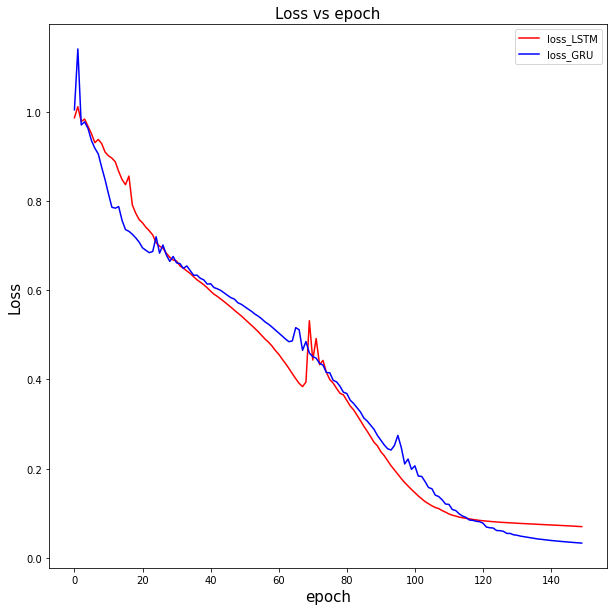

In [30]:
fig=plt.figure(figsize=(10, 10))

plt.plot(hist, color='red')
plt.plot(hist2, color='blue')
plt.title('Loss vs epoch', size=15)
plt.ylabel('Loss', size=15)
plt.xlabel('epoch', size=15)
plt.legend(['loss_LSTM','loss_GRU'])
plt.show()
fig.savefig('test.png')

### 18) Evaluación con conjunto de prueba

Puntos importantes:
- Aplicamos el modelo entrenado al conjunto test
- Convertimos el tensor de predicciones a una lista numpy
- creamos un ciclo for en el cual comparamos cada predicción obtenida con la etiqueta real de las muestras test (para cada modelo generado)
- Hacemos un conteo de los aciertos obtenidos y calculamos el porcentaje de exactitud.


In [27]:
##LSTM
y_test_pred_LSTM = model_LSTM(x_test)
flat_y_test_pred_LSTM =y_test_pred_LSTM.squeeze().tolist()

flat_y_test = y_test.squeeze().tolist()

print('-------PRUEBA CON CONJUNTO TEST - LSTM--------')
aciertos=0
for i in range(0,len(flat_y_test)):
    a=flat_y_test[i]
    b=int(round(flat_y_test_pred_LSTM[I],1))
    if a==b:
        aciertos+=1

E=round(((aciertos)/len(flat_y_test))*100,1)

t = PrettyTable(['# muestras','Predicciones acertadas en el conjunto test (%)'])
t.add_row([len(flat_y_test),E])
print(t)

###GRU
y_test_pred_GRU = model_GRU(x_test)
flat_y_test_pred_GRU =y_test_pred_GRU.squeeze().tolist()

print('-------PRUEBA CON CONJUNTO TEST - GRU--------')
aciertos=0
for i in range(0,len(flat_y_test)):
    a=flat_y_test[i]
    b=int(round(flat_y_test_pred_GRU[I],1))
    if a==b:
        aciertos+=1

E=round(((aciertos)/len(flat_y_test))*100,1)
t = PrettyTable(['# muestras','Predicciones acertadas en el conjunto test (%)'])
t.add_row([len(flat_y_test),E])
print(t)

-------PRUEBA CON CONJUNTO TEST - LSTM--------
+------------+------------------------------------------------+
| # muestras | Predicciones acertadas en el conjunto test (%) |
+------------+------------------------------------------------+
|    2869    |                      58.0                      |
+------------+------------------------------------------------+
-------PRUEBA CON CONJUNTO TEST - GRU--------
+------------+------------------------------------------------+
| # muestras | Predicciones acertadas en el conjunto test (%) |
+------------+------------------------------------------------+
|    2869    |                      54.7                      |
+------------+------------------------------------------------+


### 18) Tiempos de ejecución para cada entrenamiento realizado

In [31]:
t = PrettyTable(['LSTM (s)','GRU (s)'])
t.add_row([round(training_time,1),round(training_time2,1)])
print(t)

+----------+---------+
| LSTM (s) | GRU (s) |
+----------+---------+
|  2207.0  |  2269.3 |
+----------+---------+
